In [1]:
# coding: utf-8
import numpy as np
from matplotlib import pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.kernel_approximation
import scipy.optimize as opt
import UCB_new
from UCB_new import DummyEnvironment
from pickle import load
import bz2
import optwok
import random
import qreg
from qreg import QRegressor

%matplotlib inline

### Compare the performance of GPUCB and QuantUCB on toy data

Cheng: There is a bandit algorithm, called GP-UCB, which looks at estimating the upper confidence bound using Gaussian processes, and then choosing the point that maximises the UCB as the point to sample. The idea is to do Quant-UCB, which is to use a quantile (e.g. 90%) instead of the Gaussian variance.

This notebook is to compare the performance of GPUCB and QuantUCB.

Toy data: $$10 \times sin(x) + \text{skew normal}(0, 0.1, 4)$$


In [2]:
# Class to generate samples

class DummyEnvironment(object):
    def rand_skew_norm(self, fAlpha, fLocation, fScale):
        sigma = fAlpha / np.sqrt(1.0 + fAlpha**2) 

        afRN = np.random.randn(2)
        u0 = afRN[0]
        v = afRN[1]
        u1 = sigma*u0 + np.sqrt(1.0 -sigma**2) * v 

        if u0 >= 0:
            return u1*fScale + fLocation 
        return (-u1)*fScale + fLocation 

    def sample(self, x):
        #noise = np.random.normal(0,0.1,1)
        noise = self.rand_skew_norm(0,0.1,4)
        return 10 * np.sin(x) + noise
        #return np.sin(x)
        
    def sample_withoutnoise(self, x):
        return 10 * np.sin(x)

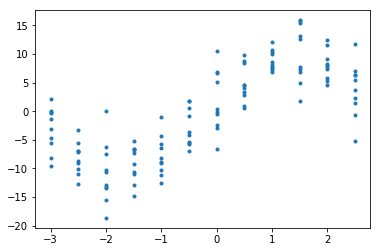

In [3]:
# generate samples points to show what the distribution looks like.

x = np.arange(-3, 3, 0.5)
# y = np.arange(-3, 3, 0.25)
env = DummyEnvironment()
x_list = []
t_list = []
for n in range(10):
    for i in x:
        t = env.sample(i)
        x_list.append(i)
        t_list.append(t)

plt.plot(x_list, t_list,'.')

In [4]:
# set test range
x = np.asarray(x_list)
t = np.asarray(t_list)

min_val = min(x)
max_val = max(x)
test_range = np.arange(min_val - 1, max_val + 1, 0.1)

### Gaussian process regression on toy dataset

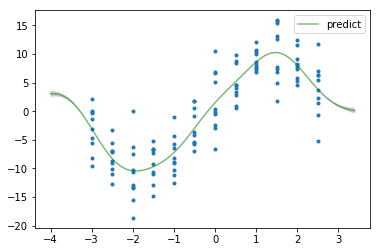

In [5]:
gp = GaussianProcessRegressor(alpha = 0.01)
gp.fit(x.reshape((x.shape[0],1)), t)
mu, sigma = gp.predict(test_range.reshape((test_range.shape[0],1)), return_std=True)

plt.plot(x,t,'.')
plt.plot(test_range, mu, alpha=0.5, color='g', label = 'predict')
plt.fill_between(test_range, mu - sigma, mu + sigma, facecolor='k', alpha=0.2)
plt.legend()

### Quantile Regression on toy dataset

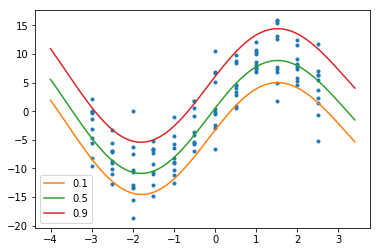

In [6]:
probs = [0.1,0.5,0.9]
probs_name = ['0.1','0.5','0.9']
reg = QRegressor(C=1e2, probs=probs, gamma_out=1e-2, max_iter=1e4,
                 verbose=False, lag_tol=1e-3, active_set=True)
reg.fit(x,t, probs)
pred = reg.predict(test_range)
plt.plot(x,t,'.')
for i, q in enumerate(pred):
    plt.plot(test_range, q, '-', label = probs_name[i])
plt.legend()

In [7]:
# setting for ucb simulation
x = np.arange(-3, 3, 0.2)
num_rounds = 100

### Simulate GP-UCB

In  0 iteration, selected:  [2.0000000000000044]  best:  1.600000000000004
In  1 iteration, selected:  [2.0000000000000044]  best:  1.600000000000004
In  2 iteration, selected:  [1.8000000000000043]  best:  1.600000000000004
In  3 iteration, selected:  [1.8000000000000043]  best:  1.600000000000004
In  4 iteration, selected:  [1.8000000000000043]  best:  1.600000000000004
In  5 iteration, selected:  [1.8000000000000043]  best:  1.600000000000004
In  6 iteration, selected:  [1.8000000000000043]  best:  1.600000000000004
In  7 iteration, selected:  [2.0000000000000044]  best:  1.600000000000004
In  8 iteration, selected:  [1.400000000000004]  best:  1.600000000000004
In  9 iteration, selected:  [2.0000000000000044]  best:  1.600000000000004
In  10 iteration, selected:  [2.0000000000000044]  best:  1.600000000000004
In  11 iteration, selected:  [1.2000000000000037]  best:  1.600000000000004
In  12 iteration, selected:  [1.2000000000000037]  best:  1.600000000000004
In  13 iteration, selec

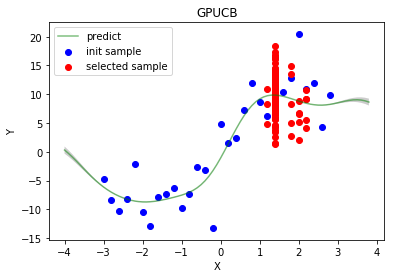

In [8]:
alpha = 0.01 
GPAgent = UCB_new.GPUCB(env,x,alpha)
GPAgent.init_reward()
for i in range(num_rounds):
    GPAgent.learn(i) 
GPAgent.plot()

### Simulate QuantUCB with maximum upper quantile

$$x_t = argmax_{x \in D} q_{\alpha_t}(x)$$

choice of $\alpha_t$:

0.5 + log(t + 1)/(num_rounds * 2)

In  0 iteration, selected:  2.400000000000005  best:  1.600000000000004
In  1 iteration, selected:  2.400000000000005  best:  1.600000000000004
In  2 iteration, selected:  2.400000000000005  best:  1.600000000000004
In  3 iteration, selected:  2.400000000000005  best:  1.600000000000004
In  4 iteration, selected:  2.400000000000005  best:  1.600000000000004
In  5 iteration, selected:  2.400000000000005  best:  1.600000000000004
In  6 iteration, selected:  2.400000000000005  best:  1.600000000000004
In  7 iteration, selected:  2.400000000000005  best:  1.600000000000004
In  8 iteration, selected:  2.400000000000005  best:  1.600000000000004
In  9 iteration, selected:  2.2000000000000046  best:  1.600000000000004
In  10 iteration, selected:  2.2000000000000046  best:  1.600000000000004
In  11 iteration, selected:  2.2000000000000046  best:  1.600000000000004
In  12 iteration, selected:  2.400000000000005  best:  1.600000000000004
In  13 iteration, selected:  2.400000000000005  best:  1.6

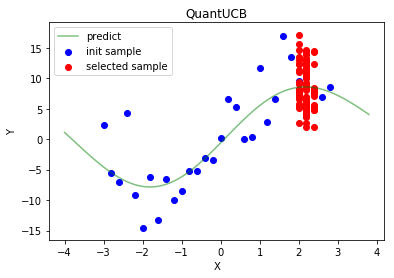

In [9]:
QuantAgent = UCB_new.QuantUCB_MUB(env, x)
QuantAgent.init_reward()
for i in range(num_rounds):
    QuantAgent.learn(i, num_rounds)
QuantAgent.plot()

### Plot cumulative regret

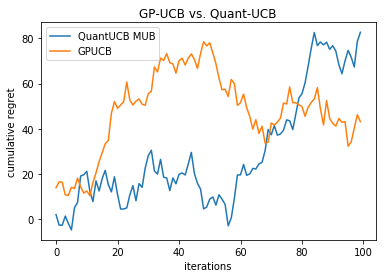

In [10]:
plt.plot(range(num_rounds), QuantAgent.regret_list, label = 'QuantUCB MUB')
plt.plot(range(num_rounds), GPAgent.regret_list, label = 'GPUCB')
plt.xlabel('iterations')
plt.ylabel('cumulative regret')
plt.title('GP-UCB vs. Quant-UCB')
plt.legend()